# Target of this Project:
The target of this project is to use artifical intelligence in particualar different machine learning algorithms to predict the energy consumption of buildings using historical data about the past energy consumption of buildings, building meta information and weather measurements. This project is based on the Kaggle Challenge (https://www.kaggle.com/competitions/ashrae-energy-prediction/overview).

# 0. Initialize Environment

In [21]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import EarlyStopping

import xgboost as xgb

import gc
import time

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# LOAD DATA
meter_readings = pd.read_csv("meter_readings.csv")
building_meta = pd.read_csv("building_metadata.csv")
weather_meta = pd.read_csv("weather_metadata.csv")

In [3]:
meter_readings

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [4]:
building_meta

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [5]:
weather_meta

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


# 1. Data Analysis

#### meter_readings
1. building_id - Foreign key for the building metadata.
2. meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
3. timestamp - When the measurement was taken
4. meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: the site 0 electric meter readings are in kBTU.

#### building_meta
1. site_id - Foreign key for the weather files.
2. building_id - Foreign key for training.csv
3. primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
4. square_feet - Gross floor area of the building
5. year_built - Year building was opened
6. floor_count - Number of floors of the building 

#### weather_meta
1. site_id
2. air_temperature - Degrees Celsius
3. cloud_coverage - Portion of the sky covered in clouds, in oktas
4. dew_temperature - Degrees Celsius
5. precip_depth_1_hr - Millimeters
6. sea_level_pressure - Millibar/hectopascals
7. wind_direction - Compass direction (0-360)
8. wind_speed - Meters per second


source: https://www.kaggle.com/c/ashrae-energy-prediction/data

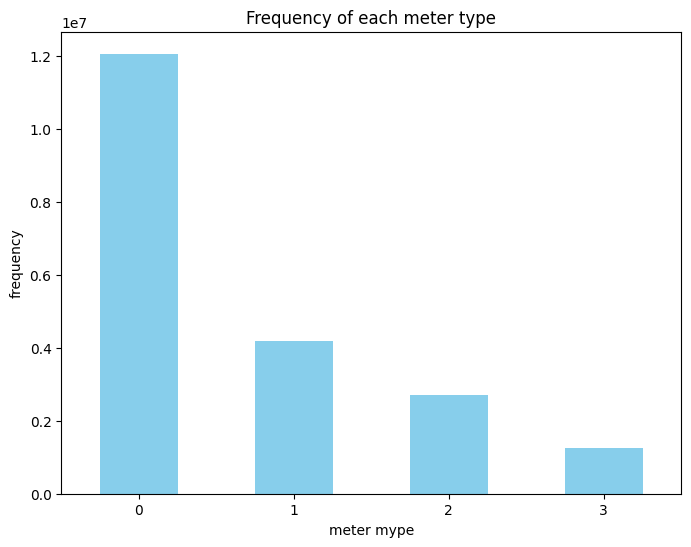

In [6]:
# PLOT THE FREQUENCY FOR EACH METER TYPE

plt.figure(figsize=(8, 6))
ax = meter_readings['meter'].value_counts().plot(kind='bar', color='skyblue')
ax.set_title("Frequency of each meter type")
ax.set_xlabel("meter mype")
ax.set_ylabel("frequency")

# Add text labels with counts above the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                fontsize=12, color='white', xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=0)
plt.show()

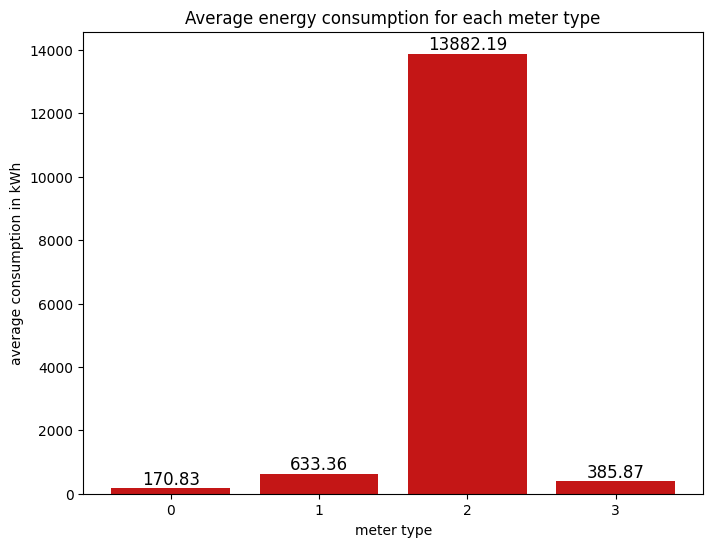

In [7]:
# PLOT AVERAGE ENERY CONSUMPTION FOR EACH METER TYPE

avgMeter = meter_readings.groupby('meter')['meter_reading'].mean().reset_index()

# Plot the average energy consumption per meter type in a bar chart
plt.figure(figsize=(8, 6))
plt.bar(avgMeter['meter'], avgMeter['meter_reading'], color='#c41616')
plt.title("Average energy consumption for each meter type")
plt.xlabel("meter type")
plt.ylabel("average consumption in kWh")

# Optionally, add value labels above the bars
for i, v in enumerate(avgMeter['meter_reading']):
    plt.text(i, v, round(v, 2), ha='center', va='bottom', fontsize=12)

plt.xticks(avgMeter['meter'])
plt.show()

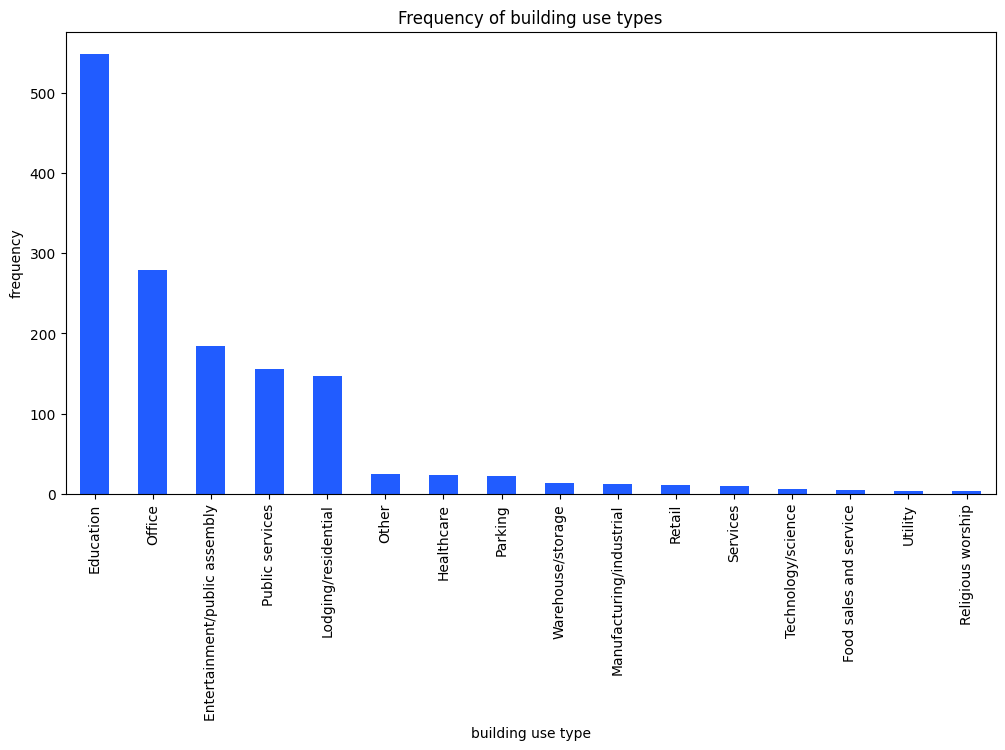

In [8]:
# PLOT FREQUENCY OF BUILDING USE TYPES

plt.figure(figsize=(12, 6))
building_meta['primary_use'].value_counts().plot(kind='bar', color='#215cff')
plt.title("Frequency of building use types")
plt.xlabel("building use type")
plt.ylabel("frequency")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

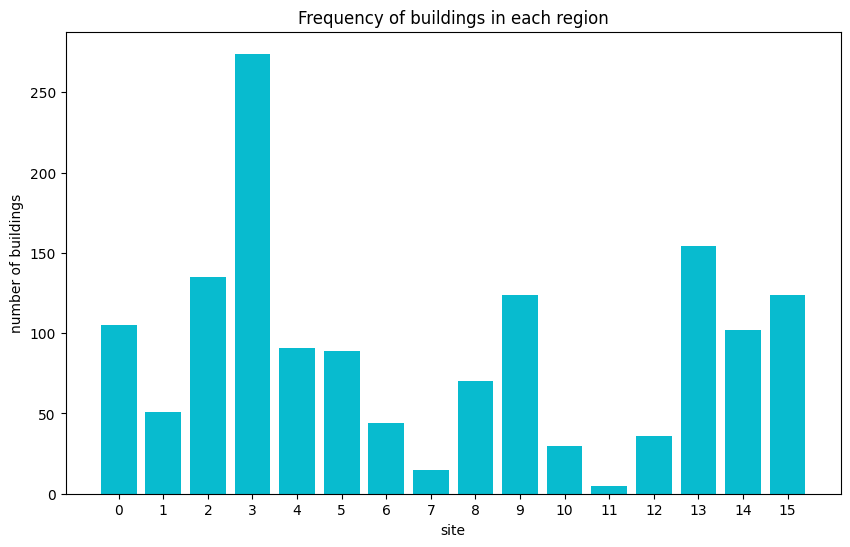

In [9]:
# Group by 'site_id' and count the distinct 'building_id'
site_bd = building_meta.groupby('site_id')['building_id'].nunique().reset_index()

# Plot the number of buildings in each site
plt.figure(figsize=(10, 6))
plt.bar(site_bd['site_id'].astype(str), site_bd['building_id'], color='#08bbcf')
plt.title("Frequency of buildings in each region")
plt.xlabel("site")
plt.ylabel("number of buildings")
plt.xticks(rotation=0)
plt.show()

C:\Users\Oguz\AppData\Local\Temp\ipykernel_4024\2441255365.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])


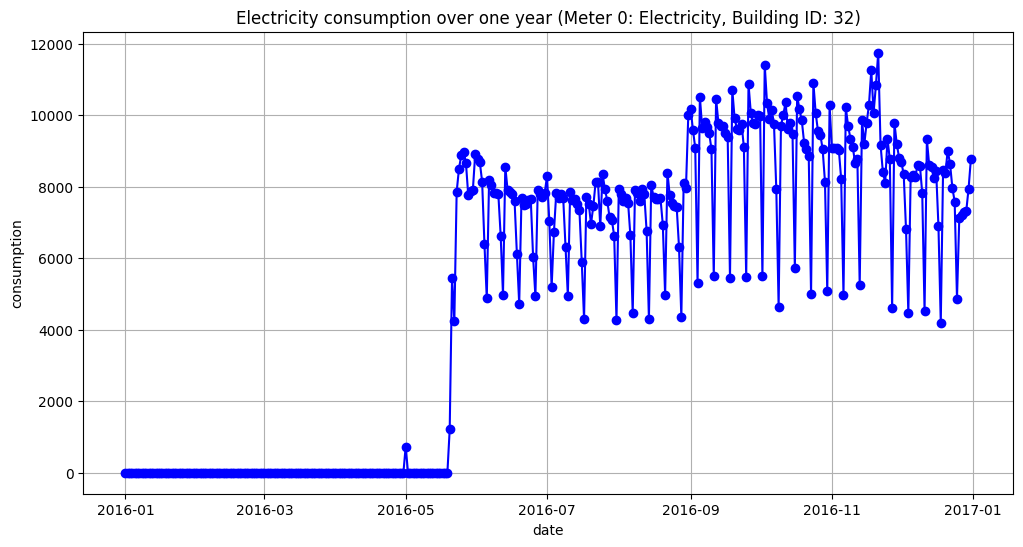

In [10]:
# PLOT ELECTRICITY CONSUMPTION OF BUILDING 0 IN A TIME SERIES

# Filter the data for 'meter' 0 and 'building_id' 0
filtered_df = meter_readings[(meter_readings['meter'] == 0) & (meter_readings['building_id'] == 32)]

# Convert the 'timestamp' column to a datetime object
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])

# Group by date and sum the meter readings for each day
daily_sum_df = filtered_df.groupby(filtered_df['timestamp'].dt.date)['meter_reading'].sum().reset_index()

# Set the 'timestamp' column as the index for time series plotting
daily_sum_df.set_index('timestamp', inplace=True)

# Plot the time series of daily electricity consumption
plt.figure(figsize=(12, 6))
plt.plot(daily_sum_df.index, daily_sum_df['meter_reading'], color='blue', linestyle='-', marker='o')
plt.title("Electricity consumption over one year (Meter 0: Electricity, Building ID: 32)")
plt.xlabel("date")
plt.ylabel("consumption")
plt.grid(True)
plt.show()

In [11]:
# CLEAR MEMORY
del ax, i, p, site_bd, v, filtered_df, daily_sum_df, avgMeter
gc.collect()

13397

# 2. Data Preproccessing

## 2.1 Handling Missing Values

Percentage of Missing Values in building meta data by feature:
site_id         0.00
building_id     0.00
primary_use     0.00
square_feet     0.00
year_built     53.42
floor_count    75.50
dtype: float64


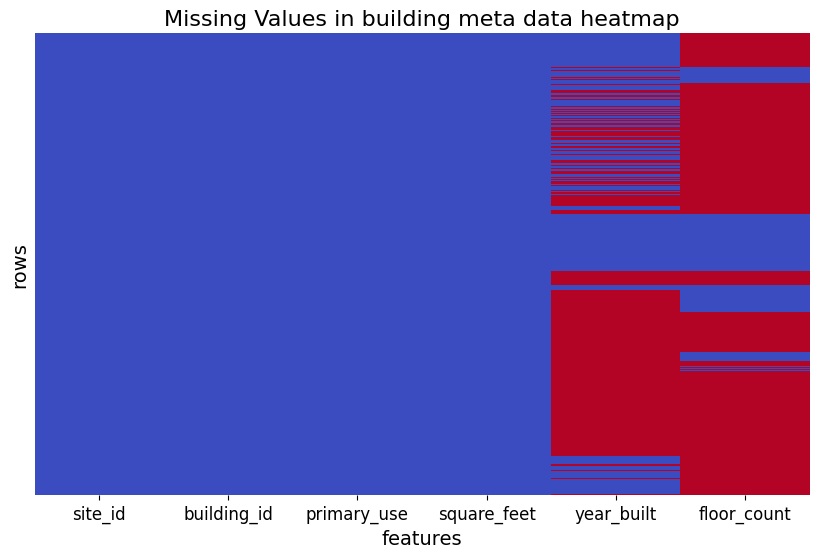

In [12]:
# Calculate the percentage of missing values for each variable
missing_percentage = (building_meta.isnull().mean() * 100).round(2)

# Print or display the missing percentage for each variable
print("Percentage of Missing Values in building meta data by feature:")
print(missing_percentage)

# Create a heatmap to visualize the missing values with improved styling
plt.figure(figsize=(10, 6))
sns.heatmap(building_meta.isnull(), cbar=False, cmap='coolwarm', yticklabels=False)
plt.title("Missing Values in building meta data heatmap", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("features", fontsize=14)
plt.ylabel("rows", fontsize=14)
plt.show()

Percentage of Missing Values in weather meta data by Feature:
site_id                0.00
timestamp              0.00
air_temperature        0.04
cloud_coverage        49.49
dew_temperature        0.08
precip_depth_1_hr     35.98
sea_level_pressure     7.60
wind_direction         4.48
wind_speed             0.22
dtype: float64


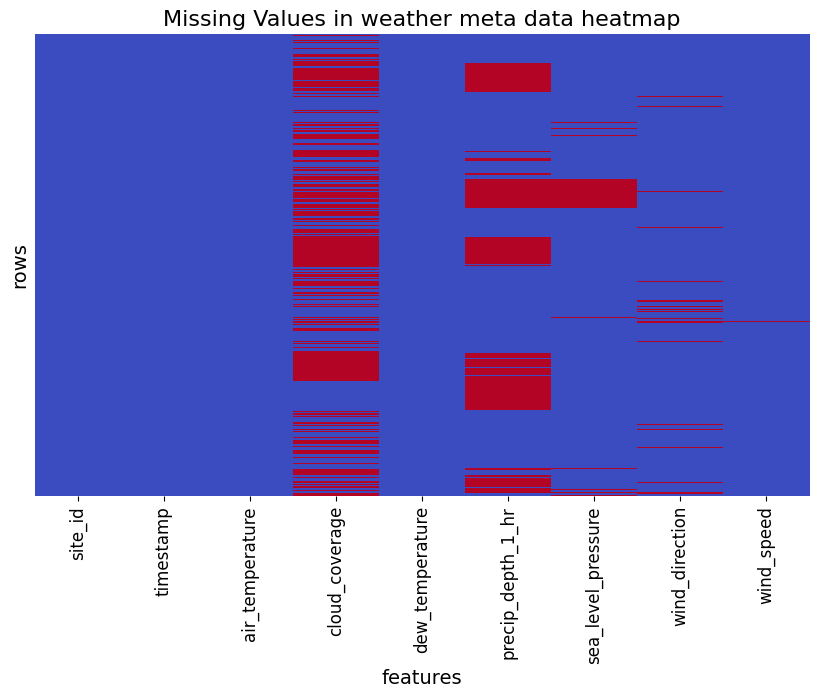

In [13]:
# Calculate the percentage of missing values for each variable
missing_percentage = (weather_meta.isnull().mean() * 100).round(2)

# Print or display the missing percentage for each variable
print("Percentage of Missing Values in weather meta data by Feature:")
print(missing_percentage)

# Create a heatmap to visualize the missing values with improved styling
plt.figure(figsize=(10, 6))
sns.heatmap(weather_meta.isnull(), cbar=False, cmap='coolwarm', yticklabels=False)
plt.title("Missing Values in weather meta data heatmap", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("features", fontsize=14)
plt.ylabel("rows", fontsize=14)
plt.show()

In [14]:
# If a feature is missing in a row we gonna add a new feature which indicates if the feature is missing "0" or is not missing "1" (doing this for features with na > 33%)

building_meta['year_built_missing'] = building_meta['year_built'].notna().astype(int)
building_meta['floor_count_missing'] = building_meta["floor_count"].notna().astype(int)

weather_meta['cloud_coverage_missing'] = weather_meta["cloud_coverage"].notna().astype(int)
weather_meta['precip_depth_1_hr_missing'] = weather_meta["precip_depth_1_hr"].notna().astype(int)

In [15]:
# Fill other features with the mean of the column

columns_to_fill = ["sea_level_pressure", 'wind_direction', 'wind_speed', "precip_depth_1_hr", "air_temperature", "dew_temperature"]

weather_meta[columns_to_fill] = weather_meta[columns_to_fill].fillna(weather_meta[columns_to_fill].mean())

building_meta['year_built'].fillna(round(building_meta['year_built'].mean(),2), inplace=True)

In [16]:
# drop columns that we dont need further

columns_to_drop = ['floor_count']
building_meta = building_meta.drop(columns=columns_to_drop)

columns_to_drop = ['cloud_coverage']
weather_meta = weather_meta.drop(columns=columns_to_drop)


In [17]:
del columns_to_fill, missing_percentage, columns_to_drop
gc.collect()

0

## 2.2 Filter for electricity meter type
In this project we will focus on the electricity consumption forcasting

In [18]:
meter_readings = meter_readings[meter_readings['meter'] == 0]

## 3.3 Join meter_readings with building and weather meta data

In [19]:
start_time = time.time()

data_part = pd.merge(meter_readings, building_meta, on="building_id")

end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

Execution time: 2.296518 seconds


In [20]:
start_time = time.time()

dataset = pd.merge(data_part, weather_meta, on=['site_id', 'timestamp'])

end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

Execution time: 3.810951 seconds


In [21]:
dataset

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,year_built_missing,floor_count_missing,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,cloud_coverage_missing,precip_depth_1_hr_missing
0,0,0,2016-01-01 00:00:00,0.000,0,Education,7432,2008.0,1,0,25.0,20.0,0.983047,1019.7,0.0,0.0,1,0
1,1,0,2016-01-01 00:00:00,0.000,0,Education,2720,2004.0,1,0,25.0,20.0,0.983047,1019.7,0.0,0.0,1,0
2,2,0,2016-01-01 00:00:00,0.000,0,Education,5376,1991.0,1,0,25.0,20.0,0.983047,1019.7,0.0,0.0,1,0
3,3,0,2016-01-01 00:00:00,0.000,0,Education,23685,2002.0,1,0,25.0,20.0,0.983047,1019.7,0.0,0.0,1,0
4,4,0,2016-01-01 00:00:00,0.000,0,Education,116607,1975.0,1,0,25.0,20.0,0.983047,1019.7,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12017403,1447,0,2016-12-31 23:00:00,159.575,15,Lodging/residential,29775,2001.0,1,0,1.7,-5.6,-1.000000,1008.5,180.0,8.8,0,1
12017404,1448,0,2016-12-31 23:00:00,2.850,15,Office,92271,2001.0,1,0,1.7,-5.6,-1.000000,1008.5,180.0,8.8,0,1
12017405,1345,0,2016-12-31 23:00:00,0.000,15,Education,20889,1976.0,1,0,1.7,-5.6,-1.000000,1008.5,180.0,8.8,0,1
12017406,1392,0,2016-12-31 23:00:00,46.825,15,Entertainment/public assembly,76153,1963.0,1,0,1.7,-5.6,-1.000000,1008.5,180.0,8.8,0,1


## 3.4 update meter_readings for region in site 0

In [22]:
dataset.loc[dataset['site_id'] == 0, 'meter_reading'] *= 0.2931

## 3.5 Extract Date and generate new features

Aus den gegebenen Timestamps können wir neue Variablen generieren, die wir für unsere Modelle nutzen können, um deren Performance zu steigern.
Folgende Variablen werden generiert:

1. month - (Januar-Dezember)
2. day - (1-31)
3. hour - number betwenn (0-23)
4. year - number

In [23]:
dataset[['date', 'time']] = dataset['timestamp'].str.split(' ', n=1, expand=True)

In [24]:
# Split 'date' into 'year', 'month', and 'day' columns
dataset[['year', 'month', 'day']] = dataset['date'].str.split('-', expand=True)

# Convert 'year', 'month', and 'day' columns to numeric if needed
dataset['year'] = dataset['year'].astype(int)
dataset['month'] = dataset['month'].astype(int)
dataset['day'] = dataset['day'].astype(int)

In [25]:
# Extract the hour from the 'time' column using a regular expression
dataset['hour'] = dataset['time'].str.extract(r'(\d+):')[0]

# Convert 'hour' column to numeric if needed
dataset['hour'] = dataset['hour'].astype(int)

In [26]:
# Drop uneeded columns
columns_to_drop = ['timestamp', 'time',"date"]
dataset = dataset.drop(columns=columns_to_drop)

In [27]:
dataset.head(5)

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,year_built_missing,floor_count_missing,air_temperature,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,cloud_coverage_missing,precip_depth_1_hr_missing,year,month,day,hour
0,0,0,0.0,0,Education,7432,2008.0,1,0,25.0,...,0.983047,1019.7,0.0,0.0,1,0,2016,1,1,0
1,1,0,0.0,0,Education,2720,2004.0,1,0,25.0,...,0.983047,1019.7,0.0,0.0,1,0,2016,1,1,0
2,2,0,0.0,0,Education,5376,1991.0,1,0,25.0,...,0.983047,1019.7,0.0,0.0,1,0,2016,1,1,0
3,3,0,0.0,0,Education,23685,2002.0,1,0,25.0,...,0.983047,1019.7,0.0,0.0,1,0,2016,1,1,0
4,4,0,0.0,0,Education,116607,1975.0,1,0,25.0,...,0.983047,1019.7,0.0,0.0,1,0,2016,1,1,0


In [28]:
# one hot encode categorical features
categorical_columns = ['primary_use']

dataset = pd.get_dummies(dataset, columns=categorical_columns)

In [29]:
dataset.head(5)

,building_id,meter,meter_reading,site_id,square_feet,year_built,year_built_missing,floor_count_missing,air_temperature,dew_temperature,...,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage
0,0,0,0.0,0,7432,2008.0,1,0,25.0,20.0,...,False,False,False,False,False,False,False,False,False,False
1,1,0,0.0,0,2720,2004.0,1,0,25.0,20.0,...,False,False,False,False,False,False,False,False,False,False
2,2,0,0.0,0,5376,1991.0,1,0,25.0,20.0,...,False,False,False,False,False,False,False,False,False,False
3,3,0,0.0,0,23685,2002.0,1,0,25.0,20.0,...,False,False,False,False,False,False,False,False,False,False
4,4,0,0.0,0,116607,1975.0,1,0,25.0,20.0,...,False,False,False,False,False,False,False,False,False,False


In [30]:
del columns_to_drop, categorical_columns, data_part, end_time, start_time, execution_time
gc.collect()

17

In [ ]:
#dataset.to_csv("preprocessed_data.csv", index=False)

In [31]:
del building_meta, meter_readings, weather_meta
gc.collect()

0

## 3.6 Create a Train-,Validation- and Testdata

In [3]:
# You can skip the data preprocessing phase and load the already preprocessed data that i uploaded on github
dataset = pd.read_csv("preprocessed_data.csv")

In [4]:
# Drop uneeded columns
columns_to_drop = ['meter']
dataset = dataset.drop(columns=columns_to_drop)

In [5]:
# scale all numeric variables

scaler = MinMaxScaler()

for column in dataset.columns:
    if pd.api.types.is_numeric_dtype(dataset[column]):
        dataset[column] = scaler.fit_transform(dataset[[column]])

In [6]:
numeric_columns = dataset.select_dtypes(include=[np.number]).columns

dataset[numeric_columns] = dataset[numeric_columns].astype(np.float32)

In [7]:
dataset.head(5)

,building_id,meter_reading,site_id,square_feet,year_built,year_built_missing,floor_count_missing,air_temperature,dew_temperature,precip_depth_1_hr,...,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage
0,0.000000,0.0,0.0,0.008173,0.923077,1.0,0.0,0.708279,0.900164,0.005765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000691,0.0,0.0,0.002786,0.888889,1.0,0.0,0.708279,0.900164,0.005765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001381,0.0,0.0,0.005822,0.777778,1.0,0.0,0.708279,0.900164,0.005765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.002072,0.0,0.0,0.026754,0.871795,1.0,0.0,0.708279,0.900164,0.005765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002762,0.0,0.0,0.132985,0.641026,1.0,0.0,0.708279,0.900164,0.005765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X = dataset.drop(columns=["meter_reading"])
y = dataset["meter_reading"]

In [9]:
# Split into train (80%), validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print("Training data shape:" + str(X_train.shape))

Training data shape:(9613926, 34)


In [11]:
del X, y, dataset, columns_to_drop, column, numeric_columns, scaler
gc.collect()

0

# 4. Modeling Machine Learning Models

In [12]:
# save results in a dictionary

results = dict()

## 4.1 Multiple Linear Regression

In [13]:
# Train Linear Regression on train data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [14]:
# make predictions on validation data
y_pred = model.predict(X_val)

# if prediction is negative set to 0, because we cant have negative energy consumption
y_pred[y_pred < 0] = 0

In [15]:
# Calculate the mean squared logarithmic error (MSLE)
msle = mean_squared_log_error(y_val, y_pred)

# Calculate the RMSLE (Root Mean Squared Logarithmic Error)
rmsle = np.sqrt(msle)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

print("Mean Squared Logarithmic Error (MSLE):", msle)
print("Root Mean Squared Logarithmic Error (RMSLE):", rmsle)

results["Multiple_Linear_Regression"] = rmsle

Mean Squared Logarithmic Error (MSLE): 1.2415847e-05
Root Mean Squared Logarithmic Error (RMSLE): 0.0035236129


## 4.2 Random Forest

In [16]:
# Train a Random Forest
model = RandomForestRegressor(n_estimators=10, max_depth= 6, min_samples_leaf= 1000, min_samples_split=2000,random_state=42)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=1000,
                      min_samples_split=2000, n_estimators=10, random_state=42)

In [17]:
# make predictions on validation data
y_pred = model.predict(X_val)

# if prediction is negative set to 0, because we cant have negative energy consumption
y_pred[y_pred < 0] = 0

In [18]:
# Calculate the mean squared logarithmic error (MSLE)
msle = mean_squared_log_error(y_val, y_pred)

# Calculate the RMSLE (Root Mean Squared Logarithmic Error)
rmsle = np.sqrt(msle)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

print("Mean Squared Logarithmic Error (MSLE):", msle)
print("Root Mean Squared Logarithmic Error (RMSLE):", rmsle)

results["Random_Forest"] = rmsle

Mean Squared Error: 6.87328446588962e-06
Root Mean Squared Error: 0.002621694960495904
R-squared: 0.6783661964409351
Mean Squared Logarithmic Error (MSLE): 6.430443576322794e-06
Root Mean Squared Logarithmic Error (RMSLE): 0.0025358319298255543


## 4.3 Deep Nueral Network

In [19]:
from keras import backend as K

def NN_RMSLE(y_actual, y_pred):
    
    return K.sqrt(K.mean(K.square(y_pred - y_actual))) 

In [22]:
model = Sequential() 

model.add(layers.Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))

model.add(layers.Dense(32, activation='tanh'))

model.add(layers.Dense(32, activation='tanh'))

model.add(layers.Dense(32, activation='tanh'))

model.add(layers.Dense(units= 1, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                1120      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4321 (16.88 KB)
Trainable params: 4321 (16.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',   # Metric to monitor for early stopping (validation loss in this case)
    patience=2,           # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best model weights when stopping
)

model.compile(optimizer='adam', loss= NN_RMSLE)
history = model.fit(
    X_train, y_train,
    epochs=25,                 # Number of training epochs
    batch_size= 512,             # Batch size for each training update
    validation_data=(X_val, y_val),  # Validation data to monitor performance
    verbose=1,                          # Verbosity level (0 = silent, 1 = progress bar, 2 = one line per epoch)
    callbacks = [early_stopping]         # early stopping if we dont improve we can stop          
)

Epoch 1/25
18778/18778 [==============================] - 36s 2ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 2/25
18778/18778 [==============================] - 34s 2ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 3/25
18778/18778 [==============================] - 35s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/25
18778/18778 [==============================] - 33s 2ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 5/25
18778/18778 [==============================] - 34s 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/25
18778/18778 [==============================] - 34s 2ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/25
18778/18778 [==============================] - 34s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/25
18778/18778 [==============================] - 34s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/25
18778/18778 [==============================] - 32s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/25
18778/18778 [==============================

In [24]:
# make predictions on validation data
y_pred = model.predict(X_val)

# if prediction is negative set to 0, because we cant have negative energy consumption
y_pred[y_pred < 0] = 0

75109/75109 [==============================] - 62s 826us/step


In [25]:
# Calculate the mean squared logarithmic error (MSLE)
msle = mean_squared_log_error(y_val, y_pred)

# Calculate the RMSLE (Root Mean Squared Logarithmic Error)
rmsle = np.sqrt(msle)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

print("Mean Squared Logarithmic Error (MSLE):", msle)
print("Root Mean Squared Logarithmic Error (RMSLE):", rmsle)

results["Deep_Neural_Network"] = rmsle

Mean Squared Error: 2.372569724684581e-06
Root Mean Squared Error: 0.0015403147554025054
R-squared: 0.888976153040586
Mean Squared Logarithmic Error (MSLE): 2.1485118e-06
Root Mean Squared Logarithmic Error (RMSLE): 0.0014657803


## 4.4 xgboost

In [26]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 150, early_stopping_rounds = 10, random_state = 42)

history = model.fit(
    X_train, y_train, 
    eval_set = [(X_train,y_train),(X_val,y_val)],            
    verbose=True 
    )

[0]	validation_0-rmse:0.00373	validation_1-rmse:0.00375
[1]	validation_0-rmse:0.00317	validation_1-rmse:0.00319
[2]	validation_0-rmse:0.00285	validation_1-rmse:0.00286
[3]	validation_0-rmse:0.00258	validation_1-rmse:0.00260
[4]	validation_0-rmse:0.00234	validation_1-rmse:0.00236
[5]	validation_0-rmse:0.00226	validation_1-rmse:0.00228
[6]	validation_0-rmse:0.00214	validation_1-rmse:0.00216
[7]	validation_0-rmse:0.00207	validation_1-rmse:0.00208
[8]	validation_0-rmse:0.00197	validation_1-rmse:0.00199
[9]	validation_0-rmse:0.00195	validation_1-rmse:0.00196
[10]	validation_0-rmse:0.00192	validation_1-rmse:0.00193
[11]	validation_0-rmse:0.00188	validation_1-rmse:0.00190
[12]	validation_0-rmse:0.00186	validation_1-rmse:0.00187
[13]	validation_0-rmse:0.00183	validation_1-rmse:0.00184
[14]	validation_0-rmse:0.00180	validation_1-rmse:0.00182
[15]	validation_0-rmse:0.00179	validation_1-rmse:0.00181
[16]	validation_0-rmse:0.00176	validation_1-rmse:0.00177
[17]	validation_0-rmse:0.00176	validation

In [27]:
# make predictions on validation data
y_pred = model.predict(X_val)

# if prediction is negative set to 0, because we cant have negative energy consumption
y_pred[y_pred < 0] = 0

In [28]:
# Calculate the mean squared logarithmic error (MSLE)
msle = mean_squared_log_error(y_val, y_pred)

# Calculate the RMSLE (Root Mean Squared Logarithmic Error)
rmsle = np.sqrt(msle)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

print("Mean Squared Logarithmic Error (MSLE):", msle)
print("Root Mean Squared Logarithmic Error (RMSLE):", rmsle)

results["xgboost"] = rmsle

Mean Squared Error: 1.4388740510185016e-06
Root Mean Squared Error: 0.0011995307868346572
R-squared: 0.9326682185809358
Mean Squared Logarithmic Error (MSLE): 1.2629897e-06
Root Mean Squared Logarithmic Error (RMSLE): 0.0011238281


# 5. Evaluation

{'Multiple_Linear_Regression': 0.0035236129, 'Random_Forest': 0.0025358319298255543, 'Deep_Neural_Network': 0.0014657803, 'xgboost': 0.0011238281}


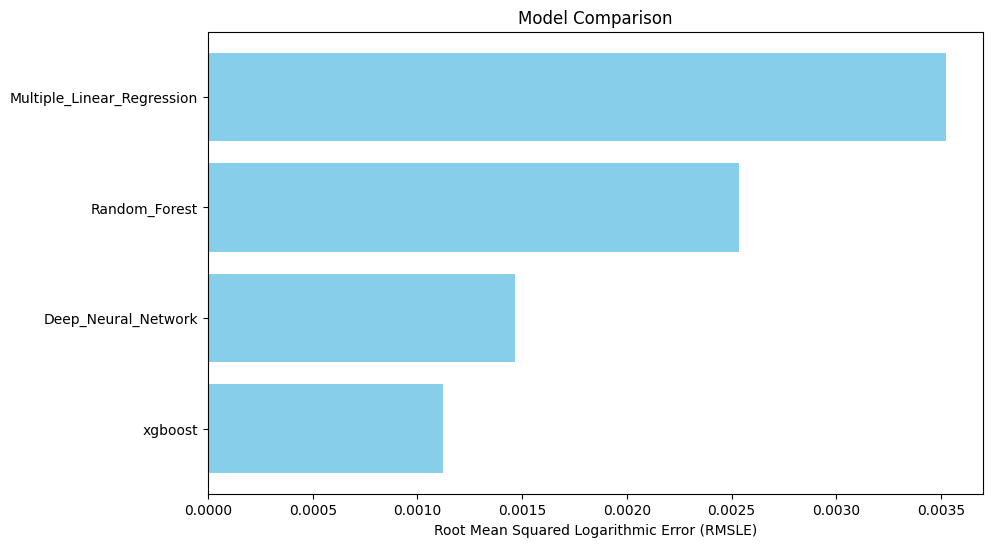

In [29]:
print(results)

# Extract model names and RMSE values
model_names = list(results.keys())
rmse_values = list(results.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(model_names, rmse_values, color='skyblue')
plt.xlabel('Root Mean Squared Logarithmic Error (RMSLE)')
plt.title('Model Comparison')
plt.gca().invert_yaxis()  # Invert the y-axis to have the best model at the top
plt.show()